## Assignment 1: Perceptron Training
Neural Networks and Computational Intelligence

In [6]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(29) # makes the random numbers predictable

In [7]:
## a) Generate artificial data sets
P = 5      # number of feature vectors 
N = 3      # dim of feature vectors

def datasets(N, P):
    D = np.zeros((N+1, P))       # empty data set (each column is a vector, last el. is the label)
    for mu in range(P):
        D[:-1, mu] = np.random.normal(0, 1, size=N)
        D[-1, mu] = np.random.randint(0, 2, size=1)        # the labels are 0 and 1 not -+1
        if D[-1, mu] == 0:
            D[-1, mu] = -1
    return D

D = datasets(N, P)
print(D)

[[-0.41748213 -2.1417555  -0.89422358  0.10193307  0.98494561]
 [ 0.7060321   0.23407402  0.80802964 -1.19332572 -1.1444064 ]
 [ 1.9159847   0.25027325 -0.20433129  0.00373976  0.38683645]
 [ 1.          1.          1.          1.         -1.        ]]


In [8]:
## b) Sequential perceptron training

n_max = 2     # max number of epochs (loops through D)
n = 1           # epoch counter
t = 0
while n <= n_max:
    print('epoch', n)
    for mu in range(P):
        print('mu('+str(t)+') = ', mu, ':', D[:-1, mu])
        t += 1 
    n += 1
print("Final t: ", t)

epoch 1
mu(0) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(1) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(2) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(3) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(4) =  4 : [ 0.98494561 -1.1444064   0.38683645]
epoch 2
mu(5) =  0 : [-0.41748213  0.7060321   1.9159847 ]
mu(6) =  1 : [-2.1417555   0.23407402  0.25027325]
mu(7) =  2 : [-0.89422358  0.80802964 -0.20433129]
mu(8) =  3 : [ 0.10193307 -1.19332572  0.00373976]
mu(9) =  4 : [ 0.98494561 -1.1444064   0.38683645]
Final t:  10


In [9]:
## c) Rosenblatt algorithm
def Ros_alg(N, P, D, n_max, c_threshold=0, verbose=False):
    w = np.zeros(N)      # weight vector
    x = np.zeros(P) # embedding strengths
    E_mu = np.zeros(P)    # local potentials (one per input vector)
    n = 1
    #t = 0
    success = False
    while n <= n_max:
        #print('epoch', n)
        for mu in range(P):
            
            E_mu[mu] = np.dot(w, D[:-1, mu]) * D[-1, mu]
            
            heav = np.heaviside(c_threshold - E_mu[mu], 1) 
            
            if heav:
                w += 1/N * heav * D[:-1, mu] * D[-1, mu] 
                x[mu] += heav

        #t += 1
        if not np.any(E_mu <= 0):
            success = True
            break
        n += 1
        
    if verbose:
        print("Success: {} after {} out of {} max epochs".format(success, n, n_max))
        
    return w, x, n, success

n_max = 10
w, x, n, s = Ros_alg(N, P, D, n_max, verbose=True)

Success: True after 4 out of 10 max epochs


In [10]:
## Rosenblatt validation algorithm
def Ros_alg_theoretical(N, P, verbose=False):
    if P <= N:
        P_ls = 1
    else:
        P_ls = 0
        for ii in range(0, N):
            P_ls += np.math.factorial(P - 1) / (np.math.factorial(ii) * np.math.factorial(P - 1 - ii))
        P_ls *= 2**(1 - P)
        
    if verbose:
        print("P_ls of N = {}, P = {} -> {:.3f}".format(N, P, P_ls))
    
    return P_ls

a = Ros_alg_theoretical(N, P, verbose=True)

P_ls of N = 3, P = 5 -> 0.688


In [11]:
## d) Running the experiments

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [5, 20, 40]

n_D = 100 * 2   # number of random datasets for each P
n_max = 100 * 5     # max number of epochs 

def do_experiment(alpha, N, n_D, n_max, c_threshold=0.0):
    P_ls = np.zeros((len(alpha), len(N)))
    P_ls_theoretical = np.zeros((len(alpha), len(N)))

    for aa in range(len(alpha)):
        print("It of alpha: {} out of {}".format(aa + 1, len(alpha)))
        for n_dim in N: 
            successful_runs = 0
            
            P = int(n_dim * alpha[aa])
            for dd in range(n_D):
                D = datasets(n_dim, P) # new generated dataset
                ww, xx, nn, ss = Ros_alg(n_dim, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
                successful_runs += ss
                
            P_ls[aa, N.index(n_dim)] = successful_runs / n_D
            P_ls_theoretical[aa, N.index(n_dim)] = Ros_alg_theoretical(n_dim, P)
            
    return P_ls, P_ls_theoretical

P_ls, P_ls_theoretical = do_experiment(alpha, N_sizes, n_D, n_max, c_threshold=0.0)


It of alpha: 1 out of 23
It of alpha: 2 out of 23
It of alpha: 3 out of 23
It of alpha: 4 out of 23
It of alpha: 5 out of 23
It of alpha: 6 out of 23
It of alpha: 7 out of 23
It of alpha: 8 out of 23
It of alpha: 9 out of 23
It of alpha: 10 out of 23
It of alpha: 11 out of 23
It of alpha: 12 out of 23
It of alpha: 13 out of 23
It of alpha: 14 out of 23
It of alpha: 15 out of 23
It of alpha: 16 out of 23
It of alpha: 17 out of 23
It of alpha: 18 out of 23
It of alpha: 19 out of 23
It of alpha: 20 out of 23
It of alpha: 21 out of 23
It of alpha: 22 out of 23
It of alpha: 23 out of 23


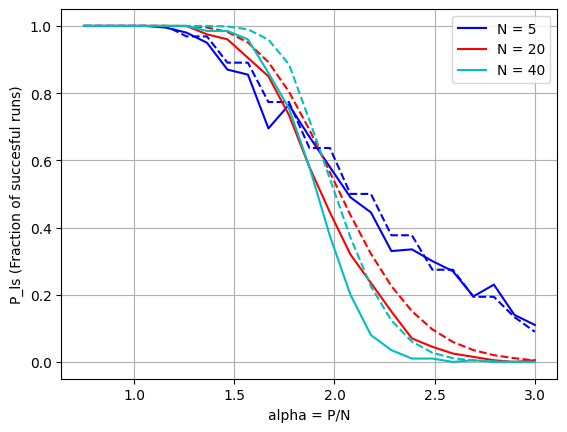

In [12]:
## Save and plot the results

def plot_save_results(N_sizes, P_ls, P_ls_theoretical, name):
    out_folder = "Results/"
    with open(out_folder + "Pls_{}.npy".format(name), 'wb') as f:
        np.save(f, P_ls)
        np.save(f, P_ls_theoretical)

    plt.figure()
    colors = ["b", "r", "c", "g", "y", "m", "k"]
    for ii in range(len(N_sizes)):
        plt.plot(alpha, P_ls[:, ii], colors[ii]+"-", label="N = {}".format(N_sizes[ii]))
        plt.plot(alpha, P_ls_theoretical[:, ii], colors[ii]+"--")

    plt.xlabel('alpha = P/N')
    plt.ylabel('P_ls (Fraction of succesful runs)')
    plt.grid()
    plt.legend()
    plt.show()

plot_save_results(N_sizes, P_ls, P_ls_theoretical, "1")

In [13]:
## Bonus: Observe the behavior of Q_ls for different system sizes N

min_alpha = 1.5; max_alpha = 2.5; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))

N_sizes = [5, 20, 40, 60, 80, 100]

n_D = 100   # number of random datasets for each P
n_max = 100     # max number of epochs 

P_ls, P_ls_theoretical = do_experiment(alpha, N_sizes, n_D, n_max)
plot_save_results(N_sizes, P_ls, P_ls_theoretical, "bonus1")

It of alpha: 1 out of 10
It of alpha: 2 out of 10
It of alpha: 3 out of 10
It of alpha: 4 out of 10
It of alpha: 5 out of 10
It of alpha: 6 out of 10
It of alpha: 7 out of 10
It of alpha: 8 out of 10
It of alpha: 9 out of 10


KeyboardInterrupt: 

In [41]:
## Bonus Embedding Strengths
P = 60
N = 30

n_D = 1  # you only do one experiment cause I doesnt make sense to sum xx from several
n_max = 100      # max number of epochs 

def do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0):
    D = datasets(N, P) # new generated dataset
    ww, xx, nn, ss = Ros_alg(N, P, D, n_max, c_threshold=c_threshold)    #I think I dont need w for anything
    return xx

embedding_strengths= do_experiment_emb(P, N, n_D, n_max, c_threshold=0.0)



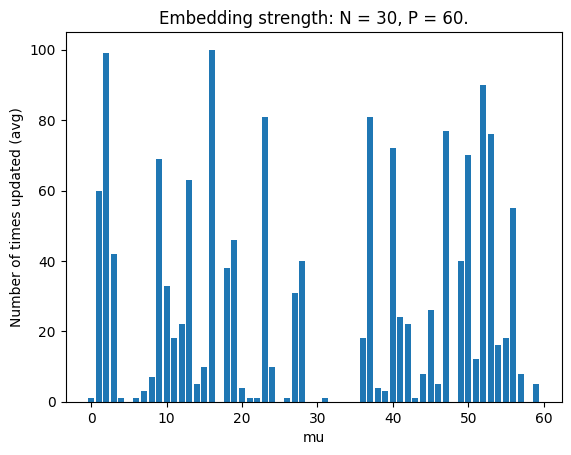

In [42]:
bins = np.arange(0, P, 1) 
plt.bar(bins, embedding_strengths)
plt.title("Embedding strength: N = {}, P = {}.".format(N,P))
plt.ylabel('Number of times updated (avg)')
plt.xlabel('mu')
plt.show()

# we need to comment that so many are not used

In [ ]:
## Bonus: Consider a non-zero value of c

min_alpha = 0.75; max_alpha = 3; step_alpha = 0.1
alpha = np.linspace(min_alpha, max_alpha, int(np.ceil((max_alpha - min_alpha) / step_alpha)))
N_sizes = [20]

n_D = 100*2   # number of random datasets for each P
n_max = 100*2     # max number of epochs
c_thresholds = [0, 0.1, 0.25, 0.5] 

results = []

for cc in c_thresholds:
    print("# C: {} out of {}".format(c_thresholds.index(cc) + 1, len(c_thresholds)))
    P_ls, P_ls_theoretical = do_experiment(alpha, N_sizes, n_D, n_max, cc)
    results.append(P_ls)
    

It of alpha: 1 out of 23
It of alpha: 2 out of 23
It of alpha: 3 out of 23
It of alpha: 4 out of 23
It of alpha: 5 out of 23
It of alpha: 6 out of 23
It of alpha: 7 out of 23
It of alpha: 8 out of 23
It of alpha: 9 out of 23
It of alpha: 10 out of 23
It of alpha: 11 out of 23
It of alpha: 12 out of 23
It of alpha: 13 out of 23
It of alpha: 14 out of 23
It of alpha: 15 out of 23
It of alpha: 16 out of 23
It of alpha: 17 out of 23
It of alpha: 18 out of 23
It of alpha: 19 out of 23
It of alpha: 20 out of 23
It of alpha: 21 out of 23
It of alpha: 22 out of 23
It of alpha: 23 out of 23
It of alpha: 1 out of 23
It of alpha: 2 out of 23
It of alpha: 3 out of 23
It of alpha: 4 out of 23
It of alpha: 5 out of 23
It of alpha: 6 out of 23
It of alpha: 7 out of 23
It of alpha: 8 out of 23
It of alpha: 9 out of 23
It of alpha: 10 out of 23
It of alpha: 11 out of 23
It of alpha: 12 out of 23
It of alpha: 13 out of 23
It of alpha: 14 out of 23
It of alpha: 15 out of 23
It of alpha: 16 out of 23
It o

In [37]:
out_folder = "Results/"
with open(out_folder + "Pls_cthreshold.npy", 'wb') as f:
    for ii in range(len(c_thresholds)):
        P_ls = results[ii]
        np.save(f, P_ls)
        
colors = ["b", "r", "c", "g", "y", "m", "k"]
plt.figure()
for ii in range(len(c_thresholds)):
    
    # plt.subplot(1, 1, ii + 1) # considering now only 1 N
    
    P_ls = results[ii]

    plt.plot(alpha, P_ls[:, 0], colors[ii]+"-", label="C_threshold = {:.3f}".format(c_thresholds[ii]))

plt.xlabel('alpha = P/N')
plt.ylabel('P_ls (Fraction of succesful runs)')
plt.grid()
plt.legend()
plt.show()

NameError: name 'c_thresholds' is not defined